In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
import numpy as np

In [2]:
from Hueristic_methods.Heuristic_Method import hueristic_Method 
from ML.adaboost import adaboost
from ML.lr import linear_regression  

In [3]:
# Load the dataset
train_file_path = "./datasets/Train_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
train_data = pd.read_csv(train_file_path)

test_file_path = "./datasets/Test_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
test_data = pd.read_csv(test_file_path)

In [4]:
print(f"Length of train data: {len(train_data)}")
print(f"Length of eval data: {len(test_data)}")


Length of train data: 207359
Length of eval data: 103680


In [5]:
#Define levels
levels=5

# Parse relevant columns for all bid and ask levels
bid_columns = [f"bids[{i}].price" for i in range(levels)] + [f"bids[{i}].amount" for i in range(levels)]
ask_columns = [f"asks[{i}].price" for i in range(levels)] + [f"asks[{i}].amount" for i in range(levels)]
feature_columns = bid_columns  + ask_columns 
target_columns=['next_1st_mark_price','next_2nd_mark_price']
eval_columns=target_columns+ ["mark_price",'1st_Price_Movement',"1st_actual_direction",'2nd_Price_Movement',"2nd_actual_direction"]

# Features and target
X_train_heuristic = train_data[feature_columns+['mark_price']]
X_train = train_data[feature_columns]
y_train = train_data[target_columns]

X_eval_heuristic = test_data[feature_columns+['mark_price']]
X_test = test_data[feature_columns]

y_test = test_data[eval_columns]

In [6]:
Heuristic_Method=hueristic_Method(X_train_heuristic,X_eval_heuristic,levels)
linear_regression=linear_regression(X_train,y_train,X_test)
adaboost=adaboost(X_train,y_train['next_1st_mark_price'],X_test)


In [7]:
# Heuristic_Method Predict 
# Measure the execution time of the function
Heuristic_start_time = time.time()
Heuristic_Predict_data=Heuristic_Method.predict()
Heuristic_end_time = time.time()
execution_time_heuristic = (Heuristic_end_time - Heuristic_start_time)* 1000 
print(f"Execution_time(Heuristic_Method): {execution_time_heuristic:.2f} milliseconds")

# Linear Regression Predict 
# Measure the execution time of the function
linear_regression_start_time = time.time()
result_lr=linear_regression.predict()
linear_regression_end_time = time.time()
execution_time_lr = (linear_regression_end_time - linear_regression_start_time)* 1000 
print(f"Execution_time(Linear Regression): {execution_time_lr:.2f} milliseconds")

# Adaboost Predict 
# Measure the execution time of the function
adaboost_start_time = time.time()
adaboost_Predict_data=pd.DataFrame({"predicted_adaboost":adaboost.predict()})
adaboost_end_time = time.time()
execution_time_adaboost = (adaboost_end_time - adaboost_start_time)* 1000 
print(f"Execution_time(adaboost): {execution_time_adaboost:.2f} milliseconds")



Execution_time(Heuristic_Method): 5457.68 milliseconds
Execution_time(Linear Regression): 16.78 milliseconds
Execution_time(adaboost): 145.82 milliseconds


/Users/jyam/.local/share/virtualenvs/Data-U7ef4Qch/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jyam/.local/share/virtualenvs/Data-U7ef4Qch/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jyam/.local/share/virtualenvs/Data-U7ef4Qch/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarni

In [8]:
# combine data tgt
Evaluate_result=pd.concat([y_eval, Heuristic_Predict_data,linear_regression_Predict_data,adaboost_Predict_data], axis=1)

In [9]:
# Evaluate performance (Mean Squared Error) based on mark price
mse_heuristic = mean_squared_error(Evaluate_result["next_mark_price"], Evaluate_result["predicted_heuristic"])
print(f"Heuristic Methods MSE (Eval Set): {mse_heuristic:.2f}")

# Evaluate performance using MSE on evaluation set
mse_lr = mean_squared_error(Evaluate_result['next_mark_price'], Evaluate_result['predicted_lr'])
print(f"Linear Regression MSE (Eval Set): {mse_lr:.2f}")

# Evaluate performance using MSE on evaluation set
mse_adaboost = mean_squared_error(Evaluate_result['next_mark_price'], Evaluate_result['predicted_adaboost'])
print(f"AdaBoost MSE (Eval Set): {mse_adaboost:.2f}")

Heuristic Methods MSE (Eval Set): 6.07
Linear Regression MSE (Eval Set): 25.41
AdaBoost MSE (Eval Set): 1118.87


In [10]:
# Calculate directional accuracy
directional_accuracy_heuristic = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_heuristic"]).mean()
print(f"Directional Accuracy (heuristic): {directional_accuracy_heuristic:.2%}")

# Calculate directional accuracy
Evaluate_result.loc[:, "predicted_direction_lr"] = np.sign(Evaluate_result["predicted_lr"] - Evaluate_result["next_mark_price"])
directional_accuracy_lr = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_lr"]).mean()
print(f"Directional Accuracy (Linear Regression): {directional_accuracy_lr:.2%}")

# Calculate directional accuracy
Evaluate_result.loc[:, "predicted_direction_adaboost"] = np.sign(Evaluate_result["predicted_adaboost"] - Evaluate_result["next_mark_price"])
directional_accuracy_adaboost = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_adaboost"]).mean()
print(f"Directional Accuracy (AdaBoost): {directional_accuracy_adaboost:.2%}")

Directional Accuracy (heuristic): 36.41%
Directional Accuracy (Linear Regression): 29.83%
Directional Accuracy (AdaBoost): 23.47%


In [11]:
# Tolerance-Based Accuracy
tolerance = 0.0001 * Evaluate_result["next_mark_price"].mean()  # Set tolerance to 0.01% of average price

# Calculate tolerance-based accuracy
Evaluate_result.loc[:, "tolerance_heuristic"] = abs(Evaluate_result["predicted_heuristic"] - Evaluate_result["next_mark_price"]) <= tolerance
tolerance_accuracy_heuristic = Evaluate_result["tolerance_heuristic"].mean()
print(f"Tolerance-Based Accuracy (heuristic): {tolerance_accuracy_heuristic:.2%}")

# Calculate tolerance-based accuracy
Evaluate_result.loc[:, "tolerance_lr"] = abs(Evaluate_result["predicted_lr"] - Evaluate_result["next_mark_price"]) <= tolerance
tolerance_accuracy_lr = Evaluate_result["tolerance_lr"].mean()
print(f"Tolerance-Based Accuracy (Linear Regression): {tolerance_accuracy_lr:.2%}")

# Calculate tolerance-based accuracy
Evaluate_result.loc[:, "tolerance_adaboost"] = abs(Evaluate_result["predicted_adaboost"] - Evaluate_result["next_mark_price"]) <= tolerance
tolerance_accuracy_adaboost = Evaluate_result["tolerance_adaboost"].mean()
print(f"Tolerance-Based Accuracy (AdaBoost): {tolerance_accuracy_adaboost:.2%}")

Tolerance-Based Accuracy (heuristic): 97.25%
Tolerance-Based Accuracy (Linear Regression): 80.95%
Tolerance-Based Accuracy (AdaBoost): 18.25%


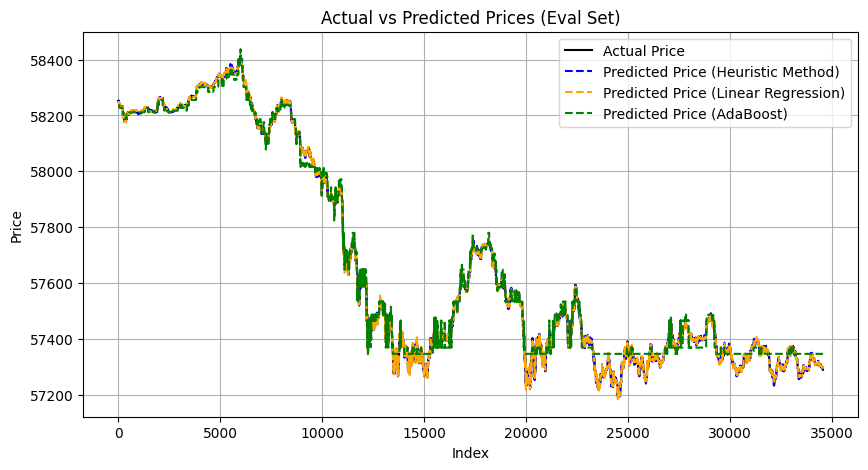

In [12]:
# Plot actual vs predicted prices
# Report Size
# plt.figure(figsize=(12, 6))

# Poster size
plt.figure(figsize=(10, 5))

# Actual
plt.plot(Evaluate_result.index, Evaluate_result["next_mark_price"], label="Actual Price", color="black")

# Predicted prices
plt.plot(Evaluate_result.index,Evaluate_result["predicted_heuristic"], label="Predicted Price (Heuristic Method)", color="blue", linestyle="--")
plt.plot(Evaluate_result.index, Evaluate_result["predicted_lr"], label="Predicted Price (Linear Regression)", color="orange", linestyle="--")
plt.plot(Evaluate_result.index, Evaluate_result["predicted_adaboost"], label="Predicted Price (AdaBoost)", color="green", linestyle="--")


plt.title("Actual vs Predicted Prices (Eval Set)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


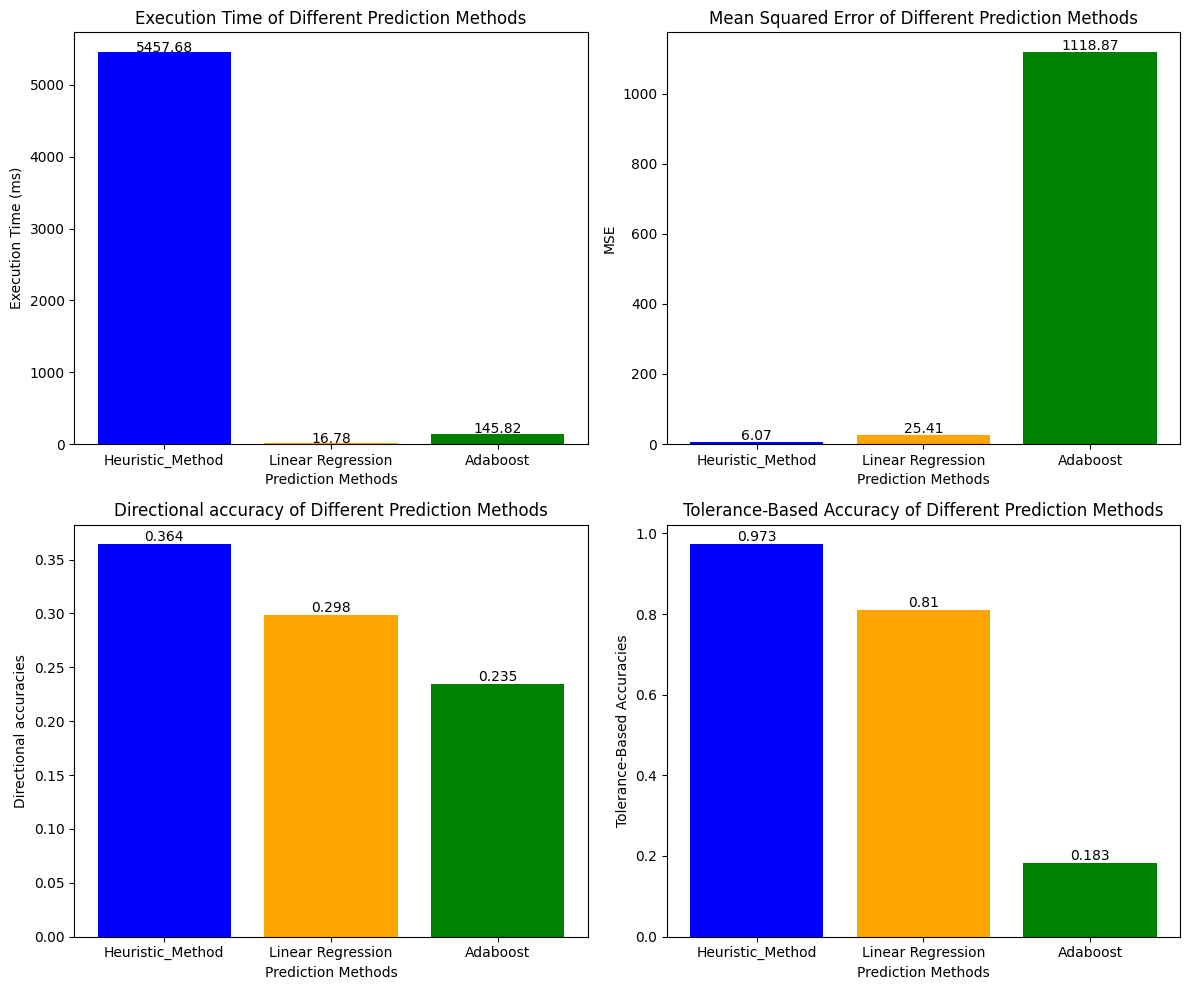

In [13]:
# Define the methods and the performance metric 
methods = ['Heuristic_Method', 'Linear Regression', 'Adaboost']
execution_times = [execution_time_heuristic, execution_time_lr, execution_time_adaboost]
mses = [mse_heuristic, mse_lr, mse_adaboost]
directional_accuracies = [directional_accuracy_heuristic, directional_accuracy_lr, directional_accuracy_adaboost]
Tolerance_accuracies= [tolerance_accuracy_heuristic, tolerance_accuracy_lr, tolerance_accuracy_adaboost]

plt.figure(figsize=(12, 10))

# Create execution_times bar chart
plt.subplot(2,2,1)
plt.bar(methods, execution_times, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Prediction Methods')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time of Different Prediction Methods')

# Display the value on top of the bars
for i, time in enumerate(execution_times):
    plt.text(i, time + 5, f"{time:.2f}", ha='center')

# Create mses bar chart
plt.subplot(2,2,2)
plt.bar(methods, mses, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Prediction Methods')
plt.ylabel('MSE')
plt.title('Mean Squared Error of Different Prediction Methods')

# Display the value on top of the bars
for i, mse in enumerate(mses):
    plt.text(i, mse + 5, f"{mse:.2f}", ha='center')

# Create directional_accuracies bar chart
plt.subplot(2,2,3)
directional_accuracies_bars=plt.bar(methods, directional_accuracies, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Prediction Methods')
plt.ylabel('Directional accuracies')
plt.title('Directional accuracy of Different Prediction Methods')

# Displaying the values on top of each bar
for bar in directional_accuracies_bars:
    height = bar.get_height()
    # plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    # Poster
    height_formatted = "{:.3g}".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2, height, height_formatted, ha='center', va='bottom')

# Create directional_accuracies bar chart
plt.subplot(2,2,4)
Tolerance_accuracies_bars=plt.bar(methods, Tolerance_accuracies, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Prediction Methods')
plt.ylabel('Tolerance-Based Accuracies')
plt.title('Tolerance-Based Accuracy of Different Prediction Methods')

# Displaying the values on top of each bar
for bar in Tolerance_accuracies_bars:
    height = bar.get_height()
    # plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    # Poster
    height_formatted = "{:.3g}".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2, height, height_formatted, ha='center', va='bottom')

# Show the charts
plt.tight_layout()
plt.show()

In [ ]:
# Performances=pd.DataFrame({"1st_mark_price_mse_lr": mse_lr[0],
#                                              "1st_mark_price_tolerance_accuracy_lr": tolerance_accuracy_lr[0],
#                                              "1st_mark_price_directional_accuracy_lr": directional_accuracy_lr[0],      
#                                              "1st_mark_price_mse_lr": mse_lr[1],
#                                              "1st_mark_price_tolerance_accuracy_lr": tolerance_accuracy_lr[1],
#                                              "1st_mark_price_directional_accuracy_lr": directional_accuracy_lr[1],
#                                              "execution_time":execution_time})

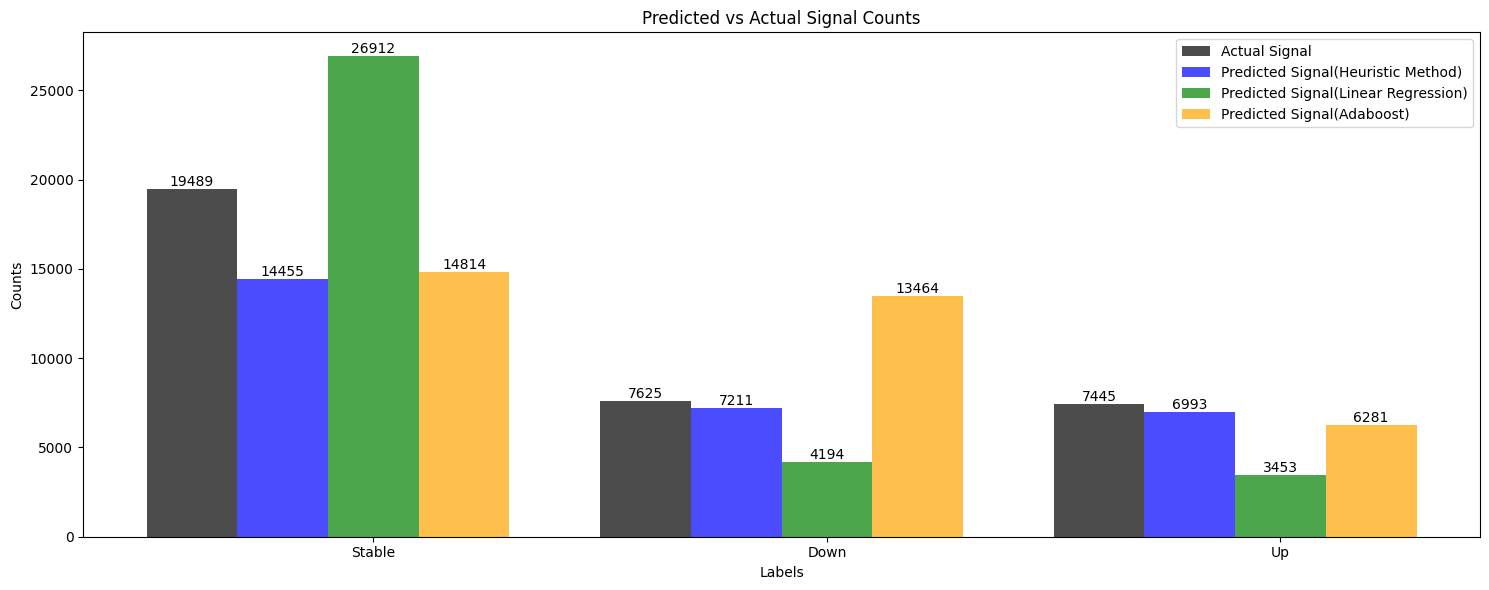

In [14]:
# Add signal distribution visualization
direction_mapping = {1.0: "up", 0.0: "stable", -1.0: "down"}
Evaluate_result["predicted_movement_heuristic"] = Evaluate_result["predicted_direction_heuristic"].map(direction_mapping)

# Add symbol columns based on comparison with the last mark price
symbol_tolerance = 0.0001 * Evaluate_result["next_mark_price"].mean()  # Adjust as needed
Evaluate_result.loc[:, "predicted_movement_lr"] = None
Evaluate_result.loc[:, "predicted_movement_adaboost"] = None


for i in range(len(Evaluate_result)):
    # Linear Regression symbol logic
    if Evaluate_result["predicted_lr"].iloc[i] > Evaluate_result["mark_price"].iloc[i] + symbol_tolerance:
        Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_lr"] = "up"
    elif Evaluate_result["predicted_lr"].iloc[i] < Evaluate_result["mark_price"].iloc[i] - symbol_tolerance:
        Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_lr"] = "down"
    else:
        Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_lr"] = "stable"

    # AdaBoost symbol logic
    if Evaluate_result["predicted_adaboost"].iloc[i] > Evaluate_result["mark_price"].iloc[i]+ symbol_tolerance:
        Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_adaboost"] = "up"
    elif Evaluate_result["predicted_adaboost"].iloc[i] < Evaluate_result["mark_price"].iloc[i] - symbol_tolerance:
        Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_adaboost"] = "down"
    else:
        Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_adaboost"] = "stable"

Actual_signal_counts = Evaluate_result["Price Movement"].value_counts()
symbol_counts_heuristic = Evaluate_result["predicted_movement_heuristic"].value_counts()
symbol_counts_lr = Evaluate_result["predicted_movement_lr"].value_counts()
symbol_counts_adaboost = Evaluate_result["predicted_movement_adaboost"].value_counts()

labels = Actual_signal_counts.index.tolist()
actual_values = Actual_signal_counts.values.tolist()

heuristic_predict_values = symbol_counts_heuristic.values.tolist()
lr_predict_values = symbol_counts_lr.values.tolist()
adaboost_predict_values = symbol_counts_adaboost.values.tolist()

# Setting the positions and width for the bars
positions = np.arange(len(labels))
bar_width = 0.2

plt.figure(figsize=(15, 6))

# Create the bar plot
bar1=plt.bar(positions - 1.5*bar_width , actual_values, bar_width, label='Actual Signal', color='black', alpha=0.7)
bar2=plt.bar(positions-0.5*bar_width, heuristic_predict_values, bar_width, label='Predicted Signal(Heuristic Method)', color='b', alpha=0.7)
bar3=plt.bar(positions+ bar_width*0.5, lr_predict_values, bar_width, label='Predicted Signal(Linear Regression)', color='green', alpha=0.7)
bar4=plt.bar(positions+ bar_width*1.5, adaboost_predict_values, bar_width, label='Predicted Signal(Adaboost)', color='orange', alpha=0.7)



# Adding labels, title, and legend
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Predicted vs Actual Signal Counts')
plt.xticks(positions + bar_width / 2, labels)
plt.legend()

# Displaying the values on top of each bar
for bar in bar1 + bar2 + bar3 + bar4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.tight_layout()
plt.show()